In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy

from optics_design_workbench import jupyter_utils

# Run simulations for various lens radii

In [2]:
#simulationMode = 'true'
simulationMode = 'pseudo'
#simulationMode = 'fans'

In [3]:
# prefer using this cell to open the FreeCAD Gui. This call is blocking
# until FreeCAD is closed again, which helps to avoid editing a FCStd 
# file from jupyter and the FreeCAD Gui in parallel.

#jupyter_utils.openFreecadGui()

In [ ]:
# prepare arrays/lists for parameters/results
radii = linspace(19, 24, 15)
results = []

# open FCStd Document as a context manager. The context manager makes sure
# the file is closed again with certainty. Keep in mind that if the file is
# open in another FreeCAD GUI, saving from the Gui will overwrite the file
# and may leads to inconsistent file versions being seen by different 
# worker processes.
with jupyter_utils.FreecadDocument() as f:

  # setup progress tracking
  jupyter_utils.setupProgressTracker(totalSimulations=len(radii))

  # try different radii
  for rad in radii:

    # update radius and placement of both spheres that form the lens
    f.Sphere001.Radius = rad
    f.Sphere001.Placement.Base = [0, 0, -rad/1.9]
    f.Sphere.Radius = rad
    f.Sphere.Placement.Base = [0, 0, rad/1.9]

    # run a simulation
    results.append( f.runSimulation(simulationMode) )


simulations done 25/25
simulations ended after 3m 37s


In [5]:
# show list of the first ten results
results[:10]

[<RawFolder simulation-run-001313/ UID=22c6f1ef-8628-47cb-b9b6-2476c030d22d>,
 <RawFolder simulation-run-001314/ UID=e7816e33-f338-4dcb-9fe9-54973d6562ae>,
 <RawFolder simulation-run-001315/ UID=d00f9f73-0145-4300-84dc-d60a3adc439c>,
 <RawFolder simulation-run-001316/ UID=0a0528c2-5891-4060-ba33-0ed2b169fa6a>,
 <RawFolder simulation-run-001317/ UID=9e6748c2-dfbc-4893-9c98-67351917003b>,
 <RawFolder simulation-run-001318/ UID=f11dcf60-7f6a-4b99-8f21-276c77775383>,
 <RawFolder simulation-run-001319/ UID=7041eb0d-a400-4457-b4c4-6b1ce7e20c17>,
 <RawFolder simulation-run-001320/ UID=bae58c69-4a10-4275-bb52-472db60699a9>,
 <RawFolder simulation-run-001321/ UID=fa1db252-bf5b-4445-abd2-2e35642d64f2>,
 <RawFolder simulation-run-001322/ UID=68725653-ac51-4b95-9517-a923491715bd>]

In [6]:
# print filesystem tree overview of first result file:
results[0].printTree()

simulation-run-001313/
  source-OpticalPointSource001/
    object-OpticalAbsorberGroup/
      <10 hit files>


# Create histograms and do Gauss fit for each histogram

In [7]:
gauss = lambda X, amp, x0, sigma: amp*exp(-(X-x0)**2/sigma**2)

In [ ]:
sigmas, x0s, _Hs = [], [], []
for r in results:
  hits = r.loadHits('*')
  hist = hits.histogram(bins=(300, 301))

  #figure(figsize=(4,4))
  #pcolormesh(X, Y, H.T)
  #show()
  
  #figure(figsize=(4,4))
  H, X = hist.hist, hist.binX
  _H = H.sum(axis=1)
  #plot(X, _H)
  try:
    (amp, x0, sigma), _ = scipy.optimize.curve_fit(gauss, X[:-1], _H, p0=(max(_H), 0, 1))
  except Exception:
    #raise
    amp, x0, sigma = nan, nan, nan
  #plot(X, gauss(X, amp, x0, sigma))
  #show()

  sigmas.append(sigma)
  x0s.append(x0)
  _Hs.append(_H)

[Optics Design 20:20:25.934889] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.OpticsDesign/raw/simulation-run-001313/**/*-hits.pkl
[Optics Design 20:20:25.957685] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.OpticsDesign/raw/simulation-run-001314/**/*-hits.pkl
[Optics Design 20:20:25.990804] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.OpticsDesign/raw/simulation-run-001315/**/*-hits.pkl
[Optics Design 20:20:26.024264] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.OpticsDesign/raw/simulation-run-001316/**/*-hits.pkl
[Optics Design 20:20:26.059979] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.OpticsDesign/raw/simulation-run-001317/**/*-hits.pkl
[Optics Design 20:20:26.093470] finding all result files in /home/bredol/Projects/strahlemann/test/freecad/lens-optimizer.Opt

In [14]:
sigmas, x0s, _Hs = [array(A) for A in (sigmas, x0s, _Hs)]

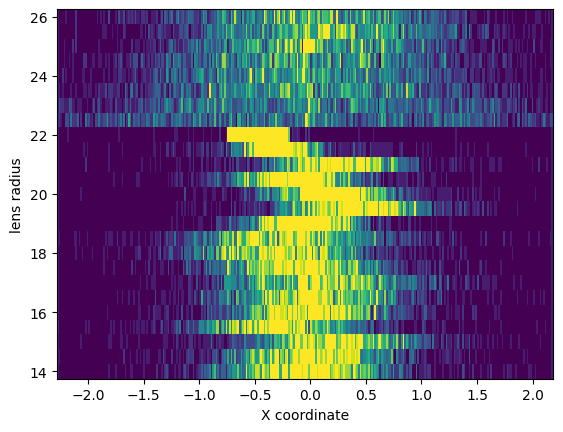

In [15]:
import matplotlib.colors as col
_Hs = array(_Hs)
pcolormesh(X[:-1], radii, _Hs, norm=col.Normalize(_Hs.min(), _Hs.max()/5, clip=True))
xlabel('X coordinate')
ylabel('lens radius')
savefig('lens-optimizer-sweep-result-cmap.jpg')

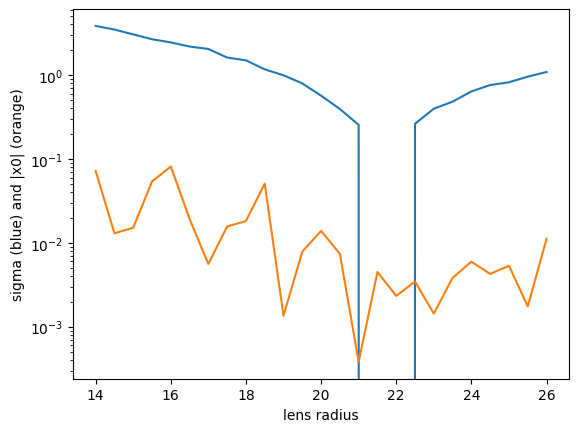

In [16]:
plot(radii, sigmas)
plot(radii, abs(x0s))
xlabel('lens radius')
ylabel('sigma (blue) and |x0| (orange)')
semilogy()
savefig('lens-optimizer-sweep-result-sigma-vs-radii.jpg')

In [17]:
rad = radii[sigmas==sigmas][argmin(sigmas[sigmas==sigmas])]
with jupyter_utils.FreecadDocument() as f:
  f.Sphere001.Radius = rad
  f.Sphere001.Placement.Base = [0, 0, -rad/1.9]
  f.Sphere.Radius = rad
  f.Sphere.Placement.Base = [0, 0, rad/1.9]